# Introduction:
 
    
    

I frequently use a 4D dataset. (3 spatial dimensions + 1 temporal dimension) 
Sometimes, I just like to see a crosssection of the data; however, an arbitrary cross-section is rather hard to get.
x-/y-/z-slices are easy but what would you do if the normal vector of the cross-section is not parallel to one of the directions of the array?

In the past, I used a brute-force algorithm. The basic idea was to make an orthogonal basis with a normal and a point that together define a plane.
Then, check the points spanned by the new basis were inside the cuboid. 
This was inefficient but it worked robustly. 

The time has come to improve this algorithm. Let's get to it.



In [92]:
import matplotlib.pyplot as plt
import itertools

def draw_cuboid(ax, xx, yy, zz, color='c', lw=2, **kwargs):
    """Draws a cuboid (projection='3d')"""

    xmin, xmax = np.nanmin(xx), np.nanmax(xx)
    ymin, ymax = np.nanmin(yy), np.nanmax(yy)
    zmin, zmax = np.nanmin(zz), np.nanmax(zz)
    rx = [xmin, xmax]
    ry = [ymin, ymax]
    rz = [zmin, zmax]
    w, h, d = xmax - xmin, ymax - ymin, zmax - zmin
    for s, e in itertools.combinations(np.array(list(itertools.product(rx, ry, rz))), 2):
        dist = np.linalg.norm(s - e)
        if dist in [w, h, d]:
            ax.plot3D(*zip(s, e), color=color, lw=lw, **kwargs)

    ax.set_xlim(rx)
    ax.set_ylim(ry)
    ax.set_zlim(rz)
    set_axes_equal(ax)
    
def set_axes_equal(ax):
    '''Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc..  This is one possible solution to Matplotlib's
    ax.set_aspect('equal') and ax.axis('equal') not working for 3D.

    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
    '''

    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])


1. Find the vertices of the cross-section<br>
A cross-section is defined by an intersecting region of an arbitrary plane with a cuboid. <br>
Let's find the corresponding vertices.

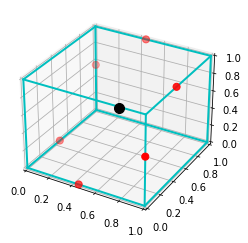

In [20]:
def get_intersecting_vertices(xxx, yyy, zzz, a, b, c, x0, y0, z0):
    """
    Returns the vertices of the cross-section
    A plane is defined by ax+by+cz=ax0 + by0 + cz0 := d
    A cuboid is expressed by xxx, yyy, zzz
    """
    def insideBox(x, y, z, xmin, xmax, ymin, ymax, zmin, zmax):
        return x >= xmin and x <= xmax and y >= ymin and y <= ymax and z >= zmin and z <= zmax
    
    d = a * x0 + b * y0 + c * z0
    
    
    xmin, xmax, ymin, ymax, zmin, zmax = xxx.min(), xxx.max(), yyy.min(), yyy.max(), zzz.min(), zzz.max()
    
    # Right plane (x=xmax)
    vert01 = [xmax, (d - a * xmax - c * zmin) / b, zmin]
    vert02 = [xmax, (d - a * xmax - c * zmax) / b, zmax]
    vert03 = [xmax, ymin, (d - a * xmax - b * ymin) / c]
    vert04 = [xmax, ymax, (d - a * xmax - b * ymax) / c]
    
    # Left plane (x=xmin)
    vert05 = [xmin, (d - a * xmin - c * zmin) / b, zmin]
    vert06 = [xmin, (d - a * xmin - c * zmax) / b, zmax]
    vert07 = [xmin, ymin, (d - a * xmin - b * ymin) / c]
    vert08 = [xmin, ymax, (d - a * xmin - b * ymax) / c]
    
    
    # Top plane (y=ymax)
    vert09 = [xmin, ymax, (d - b * ymax - a * xmin) / c]
    vert10 = [(d - b * ymax - c * zmin) / a, ymax, zmin]
    vert11 = [xmax, ymax, (d - b * ymax - a * xmax) / c]
    vert12 = [(d - b * ymax - c * zmax) / a, ymax, zmax]
    # Bottom plane (y=ymin)
    vert13 = [xmin, ymin, (d - b * ymin - a * xmin) / c]
    vert14 = [(d - b * ymin - c * zmin) / a, ymin, zmin]
    vert15 = [xmax, ymin, (d - b * ymin - a * xmax) / c]
    vert16 = [(d - b * ymin - c * zmax) / a, ymin, zmax]
    
    # Front plane (z=zmax)
    vert17 = [xmin, (d - a * xmin - c * zmax) / b, zmax]
    vert18 = [(d - b * ymin - c * zmax) / a, ymin, zmax]
    vert19 = [xmax, (d - a * xmax - c * zmax) / b, zmax]
    vert20 = [(d - b * ymax - c * zmax) / a, ymax, zmax]

    # Back plane (z=zmin)
    vert21 = [xmin, (d - a * xmin - c * zmin) / b, zmin]
    vert22 = [(d - b * ymin - c * zmin) / a, ymin, zmin]
    vert23 = [xmax, (d - a * xmax - c * zmin) / b, zmin]
    vert24 = [(d - b * ymax - c * zmin) / a, ymax, zmin]
    

    verts = [vert01, vert02, vert03, vert04,
             vert05, vert06, vert07, vert08,
             vert09, vert10, vert11, vert12,
             vert13, vert14, vert15, vert16,
             vert17, vert18, vert19, vert20,
             vert21, vert22, vert23, vert24]
    verts = set([tuple(item) for item in verts])
    verts = [vert for vert in verts if insideBox(vert[0], vert[1], vert[2], xmin, xmax, ymin, ymax, zmin, zmax)]
    if verts == []:
        raise ValueError('Given plane does not intersect with the cuboid')
    else:
        verts = np.stack(verts)
        return verts

def mag(x):
    return np.sum(np.asarray(x) ** 2) ** 0.5

# CUBOID
xmin, ymin, zmin = 0, 0, 0 # one vertex of the cuboid
lx, ly, lz = 1, 1, 1 # width, height, depth of the cuboid
xmax, ymax, zmax = xmin + lx, ymin + ly, zmin + lz
x, y, z = np.linspace(xmin, xmax), np.linspace(ymin, ymax), np.linspace(zmin, zmax)
xxx, yyy, zzz = np.meshgrid(x, y, z) # 3d positional grids

## PLANE
# A point that lies on the plane
xo, yo, zo = 0.5, 0.5, 0.55
# A plane: ax + by + cz = a x0 + b y0 + c z0 := d
a, b, c = 0.5, 0.5, -0.5

# GET INTERSECTING VERTICES
verts = get_intersecting_vertices(xxx, yyy, zzz, a, b, c, xo, yo, zo)

# PLOT
fig = plt.figure(1)
ax = plt.subplot(projection='3d')
draw_cuboid(ax, xxx, yyy, zzz)
ax.scatter(verts[:, 0], verts[:, 1], verts[:, 2], color='r', s=50)
ax.scatter([xo], [yo], [zo], color='k', s=100)


In [28]:
# Normal vector
n = np.asarray([a, b, c])
n /= mag(n)

# for example, the vector to one of the vertices from the reference is perpendicular to the normal.
ro = np.asarray([xo, yo, zo])
ro1 = verts[0] - ro

# dot product is 0
print(np.sum(n * ro1))

0.0


Let's check that the code works for any arbitrary plane and a curboid. 

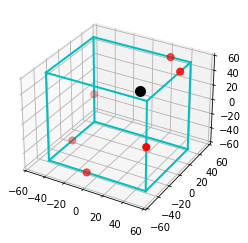

In [22]:
n=11
xmin, ymin, zmin = -50, -40, -60
lx, ly, lz = 100, 80, 120
xmax, ymax, zmax = xmin + lx, ymin + ly, zmin + lz
x, y, z = np.linspace(xmin, xmax), np.linspace(ymin, ymax), np.linspace(zmin, zmax)
xxx, yyy, zzz = np.meshgrid(x, y, z)

# A point that lies on the plane
xo ,yo, zo = 10, 20, 20

# A plane: ax + by + cz = a x0 + b y0 + c z0 := d
a, b, c = 0.5, 0.5, -0.5


verts = get_intersecting_vertices(xxx, yyy, zzz, a, b, c, xo, yo, zo)


fig = plt.figure(1)
ax = plt.subplot(projection='3d')
draw_cuboid(ax, xxx, yyy, zzz)
ax.scatter(verts[:, 0], verts[:, 1], verts[:, 2], color='r', s=50)
ax.scatter([xo], [yo], [zo], color='k', s=100)


#         ax.set_xlabel('x (mm)')
#         ax.set_ylabel('y (mm)')
#         ax.set_zlabel('z (mm)')

# verts

Good.

-0.28345040051948395 1.1113055385446435 -0.5610862801434217 0.7637007701952129


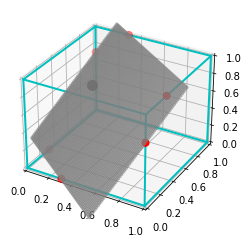

In [79]:
#
def mag(x, axis=-1):
    return np.sum(np.asarray(x) ** 2, axis=axis) ** 0.5

def dist(r1, r2):
    return mag(r2-r1)


# CUBOID
xmin, ymin, zmin = 0, 0, 0 # one vertex of the cuboid
lx, ly, lz = 1, 1, 1 # width, height, depth of the cuboid
xmax, ymax, zmax = xmin + lx, ymin + ly, zmin + lz
x, y, z = np.linspace(xmin, xmax), np.linspace(ymin, ymax), np.linspace(zmin, zmax)
xxx, yyy, zzz = np.meshgrid(x, y, z) # 3d positional grids
d = min([x[1]-x[0], y[1]-y[0], z[1]-z[0]])

## PLANE
# A point that lies on the plane
xo, yo, zo = 0.15, 0.7, 0.55
ro = np.asarray([xo, yo, zo])
# A plane: ax + by + cz = a x0 + b y0 + c z0 := d
a, b, c = 0.5, 0.5, -0.5
n = np.asarray([a, b, c]) 
n /= mag(n) # Normal vector


verts = get_intersecting_vertices(xxx, yyy, zzz, a, b, c, xo, yo, zo)
roi = verts - np.repeat(ro[np.newaxis, :], verts.shape[0], axis=0)# relative vectors from the reference to the intersecting vertices
dists = mag(roi)

# make an orthonormal basis
e1 = n # normal vector
e2 = verts[np.argmax(dists)] - ro
e2 /= mag(e2)
e3 = np.cross(e1, e2)

# Call the coordinates in the e2-e3 basis as p and q
pmin, pmax = np.min(np.dot(roi, e2)), np.max(np.dot(roi, e2))
qmin, qmax = np.min(np.dot(roi, e3)), np.max(np.dot(roi, e3))
print(pmin, pmax, qmin, qmax)

# now make a grid with the new basis
p = np.linspace(pmin, pmax, int((pmax-pmin)//d))
q = np.linspace(qmin, qmax, int((qmax-qmin)//d))
pp, qq = np.meshgrid(p, q)

xxp = ro[0] + pp * e2[0] + qq * e3[0]
yyp = ro[1] + pp * e2[1] + qq * e3[1]
zzp = ro[2] + pp * e2[2] + qq * e3[2]

# Now make


fig = plt.figure(1)
ax = plt.subplot(projection='3d')
draw_cuboid(ax, xxx, yyy, zzz)

ax.scatter(verts[:, 0], verts[:, 1], verts[:, 2], color='r', s=50)
ax.scatter([xo], [yo], [zo], color='k', s=100)


ax.scatter(xxp.flatten(), yyp.flatten(), zzp.flatten(), color='gray', alpha=0.5, s=5)


In [70]:
e1

array([ 0.57735027,  0.57735027, -0.57735027])

In [91]:
a = np.asarray([1, 2, 3])
b = np.asarray([2, 5, -1])
c = np.stack((a, b))
np.dot(a, b.T), np.stack((a, b)).shape, np.dot(a , c.T )

(9, (2, 3), array([14,  9]))

In [88]:
a.shape, b.shape

((3,), (2, 3))